
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Selection of representative cases of multivariate wave conditions to simulate with SWAN
### Maximum Dissimilarity Algorithm (MDA)

inputs required: 
  * Historical waves
  * Emulator output - wave conditions

in this notebook:
  * Split sea and swell components
  * MDA selection of representative number of events


### Workflow:

<div>
<img src="../resources/nb02_01.png" width="400px">
</div>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database, hyswan_db
from teslakit.climate_emulator import Climate_Emulator
from teslakit.mda import MaxDiss_Simplified_NoThreshold, nearest_indexes

from teslakit.plotting.mda import Plot_MDA_Data



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')

# hyswan simulation database
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)

# Climate Emulator DWTs-WVS simulations
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
WVS_sim = CE.LoadSim_All()
# --------------------------------------
# Set MDA parameters


In [3]:
WVS_sim

,DWT,sea_Hs,sea_Tp,sea_Dir,swell_1_Hs,swell_1_Tp,swell_1_Dir,swell_2_Hs,swell_2_Tp,swell_2_Dir,wind_speed,wind_dir,mu,tau,ss,n_sim,time
0,19.0,2.830476,7.554515,89.469269,0.485772,10.369804,303.118378,0.714205,9.351366,114.676300,10.411382,69.916573,0.942186,1.000000,0.0,0,2000-01-01 00:00:00
1,18.0,2.470053,9.519672,83.166489,2.251320,14.411101,297.476624,0.548206,16.062212,74.444191,5.499544,288.366302,0.854520,0.041667,0.0,0,2000-01-04 00:00:00
2,26.0,2.516587,8.455458,96.254684,0.921328,10.978793,339.569641,0.238640,10.769627,132.614548,8.855938,179.769669,0.000000,0.000000,0.0,0,2000-01-08 00:00:00
3,18.0,2.659001,10.644677,259.501984,0.822318,9.058253,344.315155,0.130981,17.371777,150.942169,8.749677,67.079559,0.866812,0.020833,0.0,0,2000-01-11 00:00:00
4,35.0,2.108193,8.055782,353.234863,0.327759,10.712851,212.896820,0.038747,13.807611,85.415718,7.890670,81.755096,0.943757,0.680556,0.0,0,2000-01-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235040,21.0,1.491215,9.590439,34.318424,0.717192,10.582491,36.022396,2.336690,8.537787,151.475525,5.568329,60.044518,0.000000,0.000000,0.0,9,2999-12-21 00:00:00
1235041,18.0,2.276567,8.808626,80.724442,0.401999,9.572033,300.671295,0.050406,11.165343,128.718964,4.865163,107.378662,0.874044,0.062500,0.0,9,2999-12-22 00:00:00
1235042,32.0,3.314268,9.863656,83.455490,0.367855,10.029246,354.611633,0.181040,9.582941,72.150703,7.675133,244.395218,0.825408,0.020833,0.0,9,2999-12-30 00:00:00
1235043,18.0,1.441129,9.059766,77.198402,1.802036,10.657471,16.481543,0.589877,15.243070,81.542709,1.989503,86.757362,0.000000,0.000000,0.0,9,2999-12-31 00:00:00


In [4]:
#Add wind information
#WVS_with_wind = CE.LoadSim_All(TCs=False) #WVS_sim has wind information, but WVS_upd does not
#WVS_sim['wspd']=WVS_with_wind.wind_speed
#WVS_sim['wdir']=WVS_with_wind.wind_dir

## Prepare Sea and Swells data

In [6]:
def split_sea_swells(WVS):
    '''
    splits WVS dataframe data into sea waves & swell waves dataframes
    
    requires WVS to contain variables with these names:
        'sea_Hs', 'sea_Tp', 'sea_Dir'
        'swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'
        'swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'
        ...
    
    '''
    
    # store n_sim if found in WVS dataset
    vns_extra = []
    if 'n_sim' in list(WVS.columns):
        vns_extra.append('n_sim') 

    
    # Prepare SEA waves
    vns_sea = ['sea_Hs', 'sea_Tp', 'sea_Dir','wind_speed','wind_dir'] + vns_extra
    
    wvs_sea = WVS[vns_sea]
    wvs_sea.dropna(inplace=True)  # clean nans
    wvs_sea.rename(columns={"sea_Hs":"hs", "sea_Tp":"tp", "sea_Dir": "dir"}, inplace=True)  # rename columns
    wvs_sea = wvs_sea[wvs_sea["dir"]<=360]  # filter data
    
    # Prepare SWELL_1 waves
    vns_swell_1 = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'] + vns_extra

    wvs_swell_1 = WVS[vns_swell_1]
    wvs_swell_1.dropna(inplace=True)
    wvs_swell_1.rename(columns={"swell_1_Hs":"hs", "swell_1_Tp":"tp", "swell_1_Dir": "dir"}, inplace=True)
    wvs_swell_1 = wvs_swell_1[wvs_swell_1["dir"]<=360]  

    # Prepare SWELL_2 waves
    vns_swell_2 = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'] + vns_extra

    wvs_swell_2 = WVS[vns_swell_2]
    wvs_swell_2.dropna(inplace=True)
    wvs_swell_2.rename(columns={"swell_2_Hs":"hs", "swell_2_Tp":"tp", "swell_2_Dir": "dir"}, inplace=True)
    wvs_swell_2 = wvs_swell_2[wvs_swell_2["dir"]<=360]  


    # join swell data
    wvs_swell = pd.concat([wvs_swell_1, wvs_swell_2], ignore_index=True)
    
    return wvs_sea, wvs_swell


In [7]:
# --------------------------------------
# split simulated waves data by family

wvs_sea_sim, wvs_swl_sim = split_sea_swells(WVS_sim)
wvs_sea_sim['hs'] = np.where(wvs_sea_sim['hs']<=0,0.001,wvs_sea_sim['hs'])
wvs_swl_sim['hs'] = np.where(wvs_swl_sim['hs']<=0,0.001,wvs_swl_sim['hs'])

db_sim.Save('sea_dataset', wvs_sea_sim)
db_sim.Save('swl_dataset', wvs_swl_sim)



## MaxDiss Classification


MaxDiss waves parameters: 1235045 --> 500

   MDA centroids: 500/500



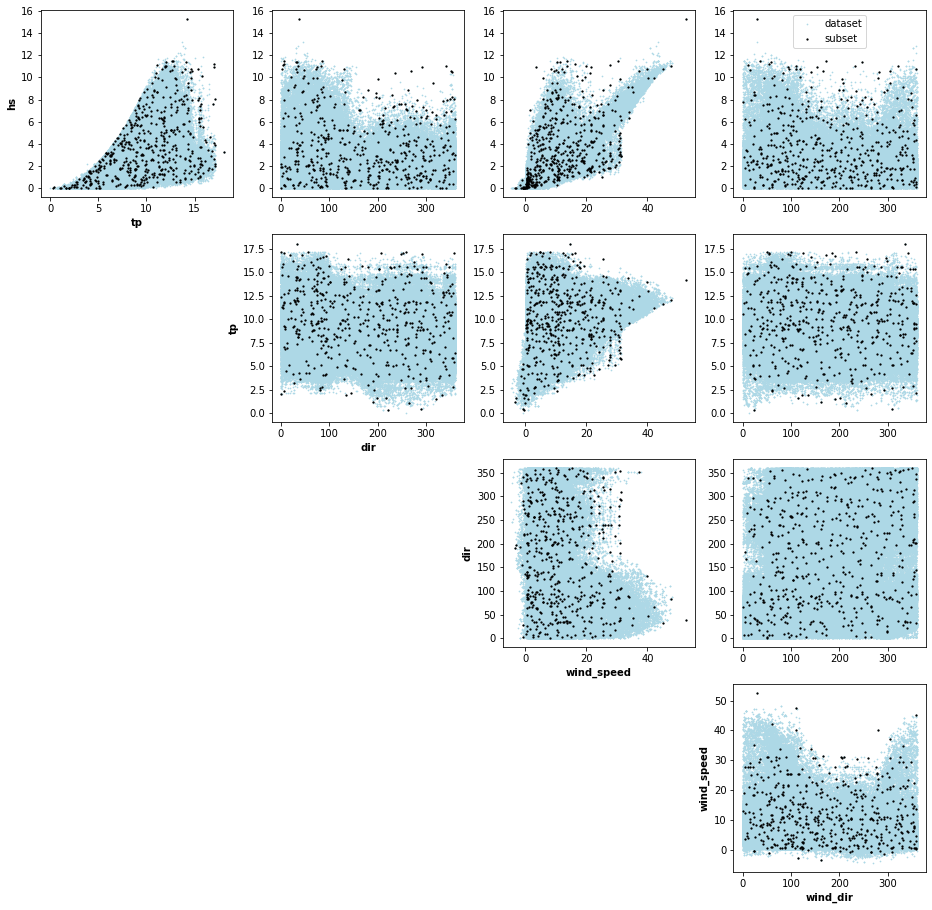

In [8]:
# --------------------------------------
# Sea

# variables to use
vns = ['hs', 'tp', 'dir','wind_speed','wind_dir']

# subset size, scalar and directional indexes
n_subset = 500      # subset size
ix_scalar = [0,1,3]           # hs, tp, wind_speed
ix_directional = [2,4]      # dir

data = wvs_sea_sim[vns].values[:]

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_sea_sim_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to sea subset
ix_n = nearest_indexes(wvs_sea_sim_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_sea_sim_subset['hs'] = wvs_sea_sim['hs'].iloc[ix_n].values[:]
wvs_sea_sim_subset['n_sim'] = wvs_sea_sim['n_sim'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_sea_sim, wvs_sea_sim_subset);

# Store MDA sea subset
db_sim.Save('sea_subset', wvs_sea_sim_subset)


In [11]:
wvs_sea_sim_subset[:20]

,hs,tp,dir,wind_speed,wind_dir,n_sim
0,15.320000,14.170001,37.880004,52.472621,30.092953,0
1,0.001000,1.626868,217.902569,-0.298944,200.983494,1
2,0.503649,3.634335,40.182706,4.408108,25.091876,9
3,9.540398,14.308791,55.821056,8.969052,208.248875,7
4,5.986013,15.488287,227.813938,12.563503,12.526697,1
5,0.001000,0.302795,220.759459,-0.435288,23.296285,3
6,4.019446,17.044514,252.843167,12.497412,183.903731,7
7,9.953939,14.679737,75.549651,5.867302,44.127287,7
8,0.001000,3.184884,27.634990,-0.504553,226.092553,8
9,2.839142,5.748503,308.798426,31.373316,113.397983,3


In [14]:
data


array([[ 10.369804, 303.11838 ],
       [ 14.411101, 297.47662 ],
       [ 10.978793, 339.56964 ],
       ...,
       [  9.582941,  72.1507  ],
       [ 15.24307 ,  81.54271 ],
       [  9.648361, 157.81429 ]], dtype=float32)


MaxDiss waves parameters: 2367770 --> 500

   MDA centroids: 500/500



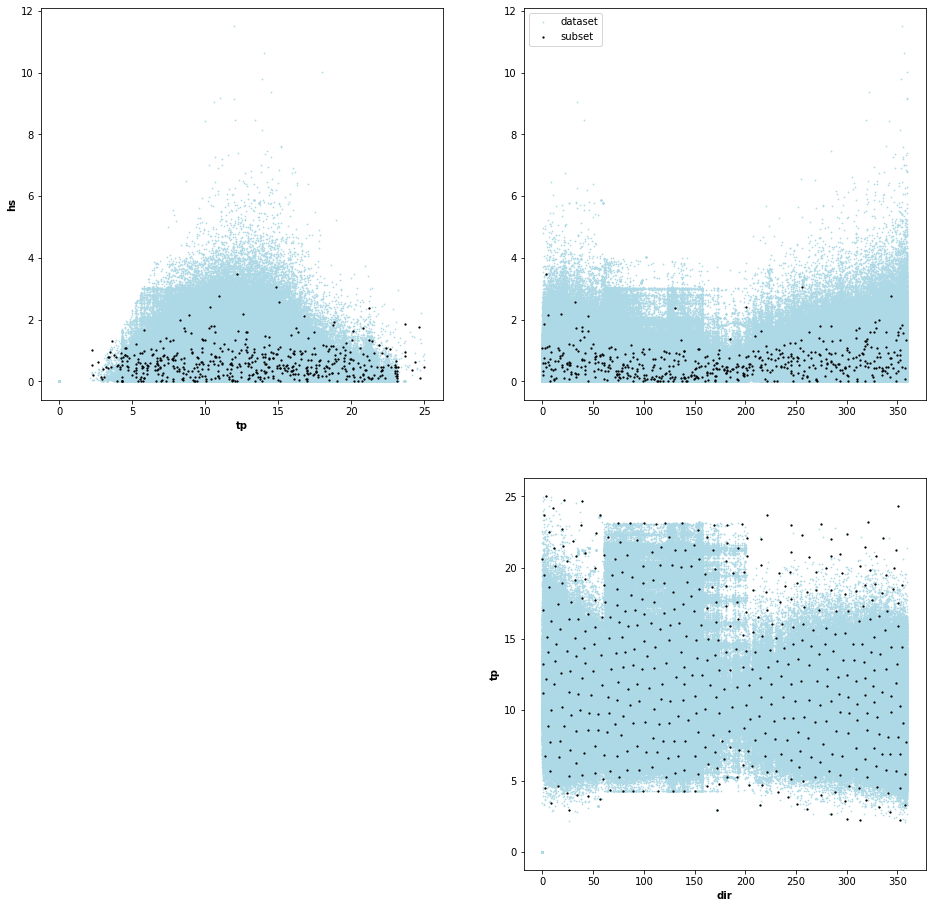

In [21]:
vns = ['tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 500          # subset size
ix_scalar = [0]           # tp
ix_directional = [1]      # dir

# --------------------------------------
# Swells
data = wvs_swl_sim[vns].values[:]
data=data[np.where(data[:,0]>0)[0],:] # Hay periodos =0 : los quitamos para el subset

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_swl_sim_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to swells subset
ix_n = nearest_indexes(wvs_swl_sim_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_swl_sim_subset['hs'] = wvs_swl_sim['hs'].iloc[ix_n].values[:]
wvs_swl_sim_subset['n_sim'] = wvs_swl_sim['n_sim'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_swl_sim, wvs_swl_sim_subset);

# Store MDA swell subset
db_sim.Save('swl_subset', wvs_swl_sim_subset)


In [22]:
wvs_swl_sim_subset[:20]

,tp,dir,hs,n_sim
0,24.997738,3.177975,0.473440,8
1,2.983132,172.500007,0.393733,9
2,2.221751,352.656300,1.017683,8
3,23.057615,196.379632,0.459633,5
4,12.997160,79.900277,0.549571,2
5,14.151002,286.828740,0.557370,3
6,3.042851,261.383498,0.126896,4
7,23.067953,111.824861,0.180622,2
8,13.466087,162.466636,0.285779,5
9,15.117866,4.124307,1.101249,6
